In [ ]:
import urllib.request


In [ ]:
#pip uninstall pillow

In [ ]:
#pip install pillow==4.0.0

In [ ]:
#pip install --user syft==0.2.9
#the code will show error if the syft version is 0.3.*. 

In [ ]:
def download_url(url, save_as):
    response = urllib.request.urlopen(url)
    data = response.read()
    file = open(save_as, 'wb')
    file.write(data)
    file.close()
    response.close()
    
def read_binary_file(file):
    f = open(file,'rb')
    block = f.read()
    return block.decode('utf-16')

def split_text_in_lines(text):
    return text.split('\r\n')

def split_by_tabs(line):
    return line.split('\t')

In [ ]:
#data_link = 'https://drive.google.com/uc?export=download&id=1J1H2ZYBPRlXNKKWJ1CjdHlRqn4AW0jSi'
data_link = 'https://drive.google.com/uc?export=download&id=1QTTCnSHNxexsS6-lGQBPv8Jui_gQ5DE1'
FedResilience_data = 'FedResilience.data'
b= download_url(data_link, FedResilience_data)

In [ ]:
import numpy as np

def parse_double(field):
    field = field.replace(',', '.')
    return float(field)

def parse_boolean(field):
    return 1. if field == 'yes' else 0.

def read_np_array(file = FedResilience_data):
    text = read_binary_file(file)
    lines = split_text_in_lines(text)
    rows = []
    for line in lines:
        if line == '': continue
        line = line.replace('\r\n', '')
        fields = split_by_tabs(line)
        row = []
        j = 0
        for field in fields:
            if j==0:
              value = parse_double(field)
            else:
              value = parse_boolean(field) 
            row.append(value)
            j += 1
        rows.append(row)
    matrix = np.array(rows, dtype = np.float32)
    return matrix

In [ ]:
def get_random_indexes(n):
    indexes = list(range(n))
    random_indexes = []
    for i in range(n):
        r = np.random.randint(len(indexes))
        random_indexes.append(indexes.pop(r))
    return random_indexes

def get_indexes_for_2_datasets(n, training = 80):
    indexes = get_random_indexes(n)
    train = int(training / 100. * n)
    return indexes[:train], indexes[train:]

matrix = read_np_array()
n_samples, n_dimensions = matrix.shape

train_indexes, test_indexes = get_indexes_for_2_datasets(n_samples)
train_data = matrix[train_indexes]
test_data = matrix[test_indexes]

def print_dataset(name, data):
    print('Dataset {}. Shape: {}'.format(name, data.shape))
    print(data)

In [ ]:
print_dataset('Train', train_data)


Dataset Train. Shape: (1600, 8)
[[27.  0.  0. ...  1.  0.  1.]
 [29.  0.  0. ...  1.  0.  1.]
 [26.  0.  0. ...  0.  0.  0.]
 ...
 [18.  0.  0. ...  0.  1.  0.]
 [42.  0.  0. ...  0.  0.  0.]
 [ 7.  0.  0. ...  0.  1.  0.]]


In [ ]:
print_dataset('Test', test_data)


Dataset Test. Shape: (400, 8)
[[31.  1.  0. ...  1.  0.  0.]
 [32.  1.  0. ...  0.  0.  0.]
 [45.  0.  0. ...  1.  0.  1.]
 ...
 [44.  1.  0. ...  1.  1.  1.]
 [39.  0.  0. ...  1.  0.  1.]
 [41.  0.  0. ...  0.  1.  0.]]


In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.5.0'

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
input_size = 6
learning_rate = 0.01
num_iterations = 2000

class LogisticRegression(torch.nn.Module):

    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [ ]:
def decide(y):
    return 1 if y >= 0.5 else 0

decide_vectorized = np.vectorize(decide)

to_percent = lambda x: '{:.2f}%'.format(x)

In [ ]:
def compute_accuracy(model, input, output):
    prediction = model(input).data.numpy()[:, 0]
    n_samples = prediction.shape[0] + 0.
    prediction = decide_vectorized(prediction)
    equal = prediction == output.data.numpy()
    return 100. * equal.sum() / n_samples

def get_input_and_output(data):
    input = Variable(torch.tensor(data[:, :6], dtype = torch.float32))
    output1 = Variable(torch.tensor(data[:, 6], dtype = torch.float32))
    output2 = Variable(torch.tensor(data[:, 7], dtype = torch.float32))
    return input, output1, output2

In [ ]:
input, output1, output2 = get_input_and_output(train_data)
test_input, test_output1, test_output2 = get_input_and_output(test_data)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

FedResilience_title1 = 'Predict Outage'
FedResilience_title2 = 'Predict Resouce-sharing Information'


In [ ]:
def plot_graphs(FedResilience_title, losses, accuracies):
    plt.plot(losses)
    plt.title(f"{FedResilience_title} - Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.show()
    plt.plot(accuracies)
    plt.title(f"{FedResilience_title} - Training Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy (Percent %)")
    plt.show()

In [ ]:
def train_model(FedResilience_title, input, output, test_input, test_output):
    model = LogisticRegression()
    criterion = torch.nn.BCELoss(size_average=True)
    #criterion = torch.nn.LogSoftmax(model)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    losses = []
    accuracies = []
    n_samples, _ = input.shape
    for iteration in range(num_iterations):
            optimizer.zero_grad()
            prediction = model(input)
           
            output = output.reshape(-1,1)
            output = output.float()
            loss = criterion(prediction, output)
            loss.backward()
            optimizer.step()
            if iteration % 10 == 0:
                train_acc = compute_accuracy(model, input, output)
                train_loss = loss.item()
                losses.append(train_loss)
                accuracies.append(train_acc)
                print('iteration={}, loss={:.4f}, train_acc={}'.format(iteration, train_loss, to_percent(train_acc)))
    plot_graphs(FedResilience_title, losses, accuracies)
    test_acc = compute_accuracy(model, test_input, test_output)
    print('\nTesting Accuracy = {}'.format(to_percent(test_acc)))
    return model

/root/.local/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


iteration=0, loss=1.8349, train_acc=75335.25%
iteration=10, loss=0.8816, train_acc=75300.00%
iteration=20, loss=0.8803, train_acc=75305.88%
iteration=30, loss=0.8780, train_acc=75305.88%
iteration=40, loss=0.8756, train_acc=75305.88%
iteration=50, loss=0.8732, train_acc=75305.88%
iteration=60, loss=0.8709, train_acc=75305.88%
iteration=70, loss=0.8686, train_acc=75317.62%
iteration=80, loss=0.8664, train_acc=75335.25%
iteration=90, loss=0.8641, train_acc=75335.25%
iteration=100, loss=0.8619, train_acc=75335.25%
iteration=110, loss=0.8597, train_acc=75370.50%
iteration=120, loss=0.8575, train_acc=75370.50%
iteration=130, loss=0.8554, train_acc=75376.38%
iteration=140, loss=0.8532, train_acc=75429.25%
iteration=150, loss=0.8511, train_acc=75429.25%
iteration=160, loss=0.8491, train_acc=75470.38%
iteration=170, loss=0.8470, train_acc=75470.38%
iteration=180, loss=0.8450, train_acc=75470.38%
iteration=190, loss=0.8429, train_acc=75488.00%
iteration=200, loss=0.8410, train_acc=75493.88%
ite

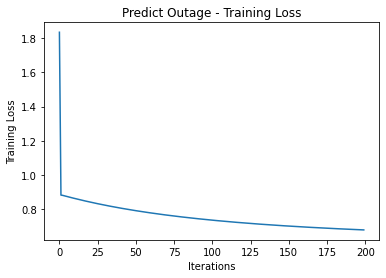

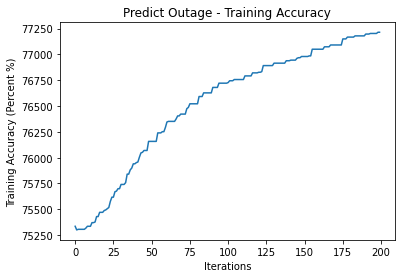


Testing Accuracy = 53.75%


In [ ]:
model = train_model(FedResilience_title1, input, output1, test_input, test_output1)


iteration=0, loss=1.3269, train_acc=127344.50%
iteration=10, loss=0.6056, train_acc=120393.12%
iteration=20, loss=0.5992, train_acc=120831.50%
iteration=30, loss=0.5930, train_acc=120831.50%
iteration=40, loss=0.5869, train_acc=121770.88%
iteration=50, loss=0.5809, train_acc=121770.88%
iteration=60, loss=0.5750, train_acc=122209.25%
iteration=70, loss=0.5692, train_acc=122710.25%
iteration=80, loss=0.5635, train_acc=123587.00%
iteration=90, loss=0.5579, train_acc=123837.50%
iteration=100, loss=0.5524, train_acc=124275.88%
iteration=110, loss=0.5470, train_acc=124401.12%
iteration=120, loss=0.5417, train_acc=124964.75%


/root/.local/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


iteration=130, loss=0.5364, train_acc=124964.75%
iteration=140, loss=0.5313, train_acc=125716.25%
iteration=150, loss=0.5263, train_acc=125716.25%
iteration=160, loss=0.5213, train_acc=126154.62%
iteration=170, loss=0.5165, train_acc=126593.00%
iteration=180, loss=0.5117, train_acc=126655.62%
iteration=190, loss=0.5070, train_acc=127782.88%
iteration=200, loss=0.5024, train_acc=127782.88%
iteration=210, loss=0.4978, train_acc=128158.62%
iteration=220, loss=0.4934, train_acc=128534.38%
iteration=230, loss=0.4890, train_acc=128534.38%
iteration=240, loss=0.4847, train_acc=128534.38%
iteration=250, loss=0.4805, train_acc=128471.75%
iteration=260, loss=0.4763, train_acc=128471.75%
iteration=270, loss=0.4722, train_acc=128471.75%
iteration=280, loss=0.4682, train_acc=128659.62%
iteration=290, loss=0.4643, train_acc=128784.88%
iteration=300, loss=0.4604, train_acc=128784.88%
iteration=310, loss=0.4566, train_acc=128784.88%
iteration=320, loss=0.4529, train_acc=128597.00%
iteration=330, loss=

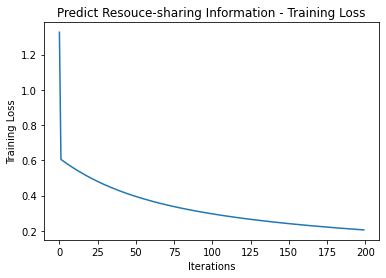

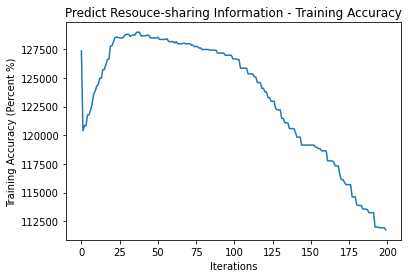


Testing Accuracy = 99.75%


In [ ]:
model = train_model(FedResilience_title2, input, output2, test_input, test_output2)


In [ ]:
#pip install --user syft==0.2.9

In [ ]:
import syft as sy
import torch as th
hook = sy.TorchHook(th)
from torch import nn, optim


In [ ]:
n_Agents = 5
Agents = []


In [ ]:
for i in range(n_Agents):
    Agent_name = 'Agent{}'.format(i)
    Agent = sy.VirtualWorker(hook, id = Agent_name)
    Agents.append(Agent)
secure_worker = sy.VirtualWorker(hook, id="secure_worker")

In [ ]:
def get_workers_names(workers):
    return [worker.id for worker in workers]

def add_and_print_workers(worker, workers):
    print('workers of {} = {}'.format(worker.id, get_workers_names(workers)))
    worker.add_workers(workers)

for i in range(n_Agents):
    workers = [Agents[i2] for i2 in range(n_Agents) if i2 != i] + [secure_worker]
    add_and_print_workers(Agents[i], workers)
add_and_print_workers(secure_worker, Agents)

Worker Agent1 already exists. Replacing old worker which could cause                     unexpected behavior
Worker Agent2 already exists. Replacing old worker which could cause                     unexpected behavior
Worker Agent3 already exists. Replacing old worker which could cause                     unexpected behavior
Worker Agent4 already exists. Replacing old worker which could cause                     unexpected behavior
Worker secure_worker already exists. Replacing old worker which could cause                     unexpected behavior
Worker Agent0 already exists. Replacing old worker which could cause                     unexpected behavior
Worker Agent2 already exists. Replacing old worker which could cause                     unexpected behavior
Worker Agent3 already exists. Replacing old worker which could cause                     unexpected behavior
Worker Agent4 already exists. Replacing old worker which could cause                     unexpected behavior
Worker secur

workers of Agent0 = ['Agent1', 'Agent2', 'Agent3', 'Agent4', 'secure_worker']
workers of Agent1 = ['Agent0', 'Agent2', 'Agent3', 'Agent4', 'secure_worker']
workers of Agent2 = ['Agent0', 'Agent1', 'Agent3', 'Agent4', 'secure_worker']
workers of Agent3 = ['Agent0', 'Agent1', 'Agent2', 'Agent4', 'secure_worker']
workers of Agent4 = ['Agent0', 'Agent1', 'Agent2', 'Agent3', 'secure_worker']
workers of secure_worker = ['Agent0', 'Agent1', 'Agent2', 'Agent3', 'Agent4']


In [ ]:
n_samples = train_data.shape[0]
samples_per_Agent = int((n_samples + 0.5) / n_Agents)
Agent_features = []
Agent_targets1 = []
Agent_targets2 = []
train_data = th.tensor(train_data, dtype = torch.float32, requires_grad=True)
for i in range(n_Agents):
    train_data2 = train_data[i * samples_per_Agent:(i + 1) * samples_per_Agent].clone().detach().requires_grad_(True)
    features = train_data2[:, :6].clone().detach().requires_grad_(True)
    targets1 = train_data2[:, 6][:, None].clone().detach() 
    targets2 = train_data2[:, 7][:, None].clone().detach() 
    Agent_features.append(features.send(Agents[i]))
    Agent_targets1.append(targets1.send(Agents[i]))
    Agent_targets2.append(targets2.send(Agents[i]))

print(model)

LogisticRegression(
  (linear): Linear(in_features=6, out_features=1, bias=True)
)


In [ ]:
def plot_federated_graphs(FedResilience_title, losses, accuracies):
    for i in range(n_Agents):
        plt.plot(losses[i], label=f'Critical Infrastructure Agent {i}')
    legend = plt.legend(loc='upper right', shadow=True)
    plt.title(f"{FedResilience_title} - Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.show()
    for i in range(n_Agents):
        plt.plot(accuracies[i], label=f'Critical Infrastructure Agent {i}')
    legend = plt.legend(loc='lower right', shadow=True)
    plt.title(f"{FedResilience_title} - Training Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy (Percent %)")
    plt.show()

In [ ]:
def compute_federated_accuracy(model, input, output):
    prediction = model(input)
    n_samples = prediction.shape[0]
    s = 0.
    for i in range(n_samples):
        p = 1. if prediction[i] >= 0.5 else 0.
        e = 1. if p == output[i] else 0.
        s += e
    return 100. * s / n_samples

iterations = 500 #2000
worker_iterations = [2, 0, 0, 0, 0]


In [ ]:
worker_iterations[0]

2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def federated_learning(FedResilience_title, Agent_features, Agent_targets, test_input, test_output):
    model = LogisticRegression()
    
    criterion = torch.nn.BCELoss(size_average=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    losses = [[] for i in range(n_Agents)]
    accuracies = [[] for i in range(n_Agents)]
    for iteration in range(iterations+1):
        models = [model.copy().send(Agents[i]) for i in range(n_Agents)]
        optimizers = [torch.optim.SGD(params = models[i].parameters(), lr = learning_rate) for i in range(n_Agents)]
        j=-1
        last_losses = []
        for i in range(n_Agents):
          j=j+1
          for worker_iteration in range(worker_iterations[j]): 
                optimizers[i].zero_grad()
                prediction = models[i](Agent_features[i])
                loss = criterion(prediction, Agent_targets[i])
                loss.backward()
                optimizers[i].step()
                loss = loss.get().data.item()
          last_losses.append(loss)
        for i in range(n_Agents):
            losses[i].append(last_losses[i])
            train_acc = compute_federated_accuracy(models[i], Agent_features[i], Agent_targets[i])
            accuracies[i].append(train_acc)
            models[i].move(secure_worker)
        with th.no_grad():
            avg_weight = sum([models[i].linear.weight.data for i in range(n_Agents)]) / n_Agents
            model.linear.weight.set_(avg_weight.get())
            avg_bias = sum([models[i].linear.bias.data for i in range(n_Agents)]) / n_Agents
            model.linear.bias.set_(avg_bias.get())
        if iteration % 5 == 0:
            losses_str = ['{:.4f}'.format(losses[i][-1]) for i in range(n_Agents)]
            accuracies_str = [to_percent(accuracies[i][-1]) for i in range(n_Agents)]
            print('Iteration={}, losses={}, accuracies={}'.format(iteration, losses_str, accuracies_str))
            if(FedResilience_title == 'Predict Outage'):
              with open('/content/gdrive/My Drive/FL Agent/Output/Latest/FedResilience_5_3_Agents_Outage.txt', 'a') as f:
                #f.write('Iteration={}, losses={}, accuracies={}\n'.format(iteration, losses_str, accuracies_str))
                #f.write('{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}\n'.format(iteration, losses_str[0],losses_str[1],losses_str[2],losses_str[3], losses_str[4],losses_str[5],losses_str[6], losses_str[7], accuracies_str[0],
                #                                          accuracies_str[1], accuracies_str[2], accuracies_str[3], accuracies_str[4], accuracies_str[5], accuracies_str[6], accuracies_str[7]))
                f.write('{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}\n'.format(iteration, losses_str[0],losses_str[1],losses_str[2],losses_str[3], losses_str[4], accuracies_str[0],
                                                          accuracies_str[1], accuracies_str[2], accuracies_str[3], accuracies_str[4]))
               # f.write('{}, {}, {}, {}, {}, {}, {}\n'.format(iteration, losses_str[0],losses_str[1], losses_str[2], accuracies_str[0],
            #                                              accuracies_str[1], accuracies_str[2]))
           
            if(FedResilience_title == 'Predict Resouce-sharing Information'):
              with open('/content/gdrive/My Drive/FL Agent/Output/Latest/FedResilience_5_3_Agents_Resource.txt', 'a') as f:
                #f.write('Iteration={}, losses={}, accuracies={}\n'.format(iteration, losses_str, accuracies_str))
                f.write('{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}\n'.format(iteration, losses_str[0],losses_str[1],losses_str[2],losses_str[3], losses_str[4], accuracies_str[0],
                                                          accuracies_str[1], accuracies_str[2], accuracies_str[3], accuracies_str[4]))
                #f.write('{}, {}, {}, {}, {}, {}, {}\n'.format(iteration, losses_str[0],losses_str[1], losses_str[2], accuracies_str[0],
                    #                                      accuracies_str[1], accuracies_str[2]))
    plot_federated_graphs(FedResilience_title, losses, accuracies)
    test_acc = compute_accuracy(model, test_input, test_output)
    print('\nTesting Accuracy = {}'.format(to_percent(test_acc)))
    j=0
    return model

In [ ]:
model = federated_learning(FedResilience_title1, Agent_features, Agent_targets1, test_input, test_output1)

/root/.local/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Iteration=0, losses=['0.5677', '0.5677', '0.5677', '0.5677', '0.5677'], accuracies=['73.75%', '79.06%', '79.38%', '73.75%', '77.81%']
Iteration=5, losses=['0.5579', '0.5579', '0.5579', '0.5579', '0.5579'], accuracies=['74.06%', '80.31%', '81.56%', '74.69%', '79.38%']
Iteration=10, losses=['0.5549', '0.5549', '0.5549', '0.5549', '0.5549'], accuracies=['75.00%', '80.31%', '81.25%', '75.00%', '80.00%']
Iteration=15, losses=['0.5532', '0.5532', '0.5532', '0.5532', '0.5532'], accuracies=['75.31%', '80.62%', '81.56%', '75.62%', '80.62%']
Iteration=20, losses=['0.5520', '0.5520', '0.5520', '0.5520', '0.5520'], accuracies=['75.31%', '80.94%', '81.88%', '75.62%', '80.62%']
Iteration=25, losses=['0.5508', '0.5508', '0.5508', '0.5508', '0.5508'], accuracies=['75.31%', '80.94%', '81.88%', '75.62%', '80.62%']
Iteration=30, losses=['0.5496', '0.5496', '0.5496', '0.5496', '0.5496'], accuracies=['75.31%', '80.94%', '81.88%', '75.62%', '80.62%']
Iteration=35, losses=['0.5485', '0.5485', '0.5485', '0.54

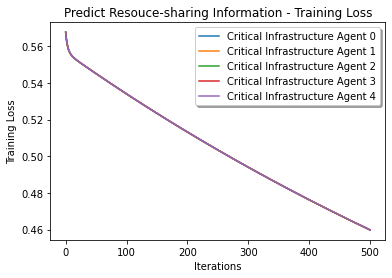

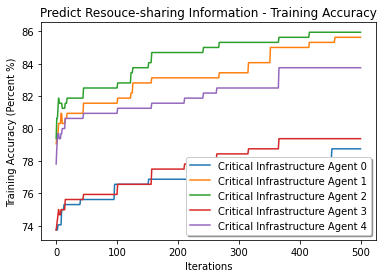


Testing Accuracy = 81.00%


In [ ]:
model = federated_learning(FedResilience_title2, Agent_features, Agent_targets2, test_input, test_output2)
